<a href="https://colab.research.google.com/github/LejoFlores/Water-in-the-West/blob/main/mod07_Watershed_Snow_Storage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 07: Snow Storage Estimation – Python Style


# Part A: Repeating Last Week's Lab

This lab largely repeats the lab you did last week in Excel. The goal is not simply to repeat it in a different way, but to help you build an ability to discern when to use which tool for a particular job. As you go through the notebook below, some good questions to reflect on include:

*  Which is harder to set up? The Excel spreadsheet? Or this Python notebook?
*  Which has higher consequences for messing something up (e.g., using the wrong tube diameter, cellsize, or snowline elevation?)
*  Which is easier to extend to a new watershed, or repeat with updated snow survey data?

Before proceeding, make sure that the following files have been uploaded to your Google Colab environment:

1. `dcew_snow_survey.csv` - CSV of snow survey data
2. `dcew_10m.tif` - A GeoTIFF containing Dry Creek DEM


In [ ]:
import numpy as np # Needed for math and computations
import matplotlib.pyplot as plt # Needed for plotting
import pandas as pd # Needed to read in CSV file
import rasterio as rio # Needed to read in GIS raster

# Define constants as they were in last week's lab
tube_dia = 4.13 # Snow tube diameter in cm
snowline_elev = 1625.0 # Elevation where snow starts
cellsize = 8.86 # DEM cell size in m

# Define names of files we need
survey_file = 'dcew_snow_survey.csv' # Snow field survey data
dcew_dem_file = 'dcew_10m.tif' # Digital elevation model of Dry Creek


We use a library called `pandas` to open the comma-separated variable file containing our snow survey data. This is the only time we'll use `pandas` in this notebook, but it is a very powerful tool for analyzing tabular data (like what you would find in Excel).

In [ ]:
surv_df = pd.read_csv(survey_file)
surv_df.head()

Now let's repeat our initial analysis to compute snow density and SWE from our survey data.

In [ ]:
# Extract individual data columns and save in appropriately named variables
elev = surv_df['elevation_m'].values
snow_depth = surv_df['snow_depth_mm'].values
field_weight = surv_df['field_weight_kg'].values

# Compute snow volume of survey data
snow_vol = np.pi * (tube_dia/2/100)**2 * (snow_depth/1000) # Note conversions to get to m^3

# Compute snow density of survey data
snow_dens = field_weight / snow_vol

In [ ]:
# Inspect snow densities
snow_dens

## 2. Perform the Regressions

### 2.1 Start with Depth Regression

In the lab in Excel, we had to create a plot of depth and density vs. elevation. Then we added a trendline and selected options to display the equation and R$^2$ value on the chart.

The logic is largely the same here, except we will call a NumPy function, whose syntax is as follows: `polyfit(x, y, n)`. This fits an order `n` polynomial to predict `y` (the "target") as a function of `x` (the "predictor"). This function will return an array of `n+1` coefficients. Note that a straight line fit is just a polynomial of order `n = 1`. So, we would expect the function to output two coefficients, which seems right because we expect a slope and an intercept.

In [ ]:
coef_depth = np.polyfit(elev, snow_depth, 1) # Fit a linear regression to snow depth vs elevation
coef_depth # Display the output coefficients.

Do these regression coefficients look familiar? They should.

Now let's compute the value of $R^2$ for our regression. Note that there are many different ways to do this, some of them involving other libraries that are more tailored to statistical modeling.

In [ ]:
depth_corr_mat = np.corrcoef(elev, snow_depth) # Compute the correlation matrix between elevation and snow depth

r_depth = depth_corr_mat[0, 1] # The single correlation coefficient between depth and elevation is in the first row, second column
r2_depth = r_depth**2 # R^2 is just r, squared

print(r2_depth) # Let's print the r^2 coefficient to see if it's correct

Now let's save the regression coefficients for later use.

In [ ]:
a = coef_depth[0] # Let 'a' equal the depth vs elevation slope
b = coef_depth[1] # Let 'b' equal the depth vs elevation intercept

### 2.2 Now Repeat the Regression with the Density Values

Now, can you use the logic from above to fit the regression line between snow density (`snow_dens`) and elevations (`elev`)?

In [ ]:
coef_dens =  # Fit a linear regression to snow density vs elevation
coef_dens

In [ ]:
dens_corr_mat =  # Compute the correlation matrix between elevation and snow density

r_dens =
r2_dens =

print(r2_dens)

Now let's save the density vs elevation regression coefficients for later use. We'll call them `c` and `d`.

In [ ]:
c =
d =

### 2.3 Let's Plot Our Results

Now let's plot our results. We'll plot both the depth vs elevation and density vs elevation plots on a single figure using the `subplot()` command. Using something like `subplot(1,2,1)` says "hey, give me two plots that are oriented as one row and two columns. And select the first one so I can plot on it."

There are many, many ways I could stylize this plot to make it more presentable and clear. I'm doing the basics here. But `matplotlib` has tons of resources to make attractive, publication/presentation-ready plots.

In [ ]:
plt.figure(figsize=(10, 5)) # Create a figure object that is 10 x 5 inches (wide x height)
plt.subplot(1, 2, 1) # Select subplot 1 in a 1 x 2 subplot array
plt.scatter(elev, snow_depth) # Create a scatter plot
plt.plot(elev, a*elev + b, 'r') # Note, we're doing the math of the regression line within the plot command!
plt.title('Snow Depth vs. Elevation') # Plot title
plt.xlabel('Elevation (m)') # Adding x-axis label
plt.ylabel('Snow Depth (mm)') # Adding y-axis label

plt.subplot(1, 2, 2)
plt. # Plot the snow density versus elevation points
plt. # Plot the regression line
plt. # Add a title
plt. # Add an x-axis label
plt. # Add a y-axis label

plt.show() # This command forces python to show the plot

## 3. Apply Regressions to Entire Watershed

### 3.1 Open the DCEW DEM File

We'll use a library called `rasterio` to deal with our GeoTIFF of the DEM in Dry Creek. Note the DEM we're working with has a resolution of about 8.8 m. So this is a much finer scale map than the one we used in Excel.

In [ ]:
dcew_dem = rio.open(dcew_dem_file) # Open the GeoTIFF file
dcew_dem = dcew_dem.read(1) # Read the first (and only) "band" of data – the elevation

dcew_dem[dcew_dem < 0] = np.nan # Fill values that are less than 0 with a NaN – see below

A note on NaNs. NaN stands for "Not a number" and is effectively a mathematical kind of "no data" flag. The cool thing about NaNs is that they behave somewhat like an undefined or infinite number. That is:

*  NaN + any real number = NaN,
*  NaN * any real number = Nan, and
*  f(NaN) = NaN

This is helpful because we have to do less book-keeping with our no-data values and can rely on math to sort it out.

### 3.2 Plot DEM to Ensure It's Correct

Let's plot our DEM. Note that we're doing a quick and dirty plot here. As such, the x- and y-axis values are just the address of each row/column and not real-world coordinates. We could certainly create plots *with* real world coordinates, but would have to use some additional libraries.

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(dcew_dem, cmap='gray') # The imshow() command is good for quick+dirty plots of images
plt.colorbar() # Shows the range of elevations
plt.show()

### 3.3 Compute the Map of Snow Depth

In [ ]:
dcew_snow_depth = np.nan * np.ones(dcew_dem.shape) # Create an empty array of numbers with the same shape as our DEM

# Use some logic to tell python to set any location of our map where the corresponding elevation is less than
# the snowline elevation equal to zero
dcew_snow_depth[dcew_dem<snowline_elev] = 0

# Conversely, any location in our map where the corresponding elevation is above the snowline elevation,
# use our depth vs elevation regression coefficients to compute the snow depth
dcew_snow_depth[dcew_dem>=snowline_elev] = a*dcew_dem[dcew_dem>=snowline_elev] + b


Now let's plot the predicted snow depth map and see if it makes sense. Does it?

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(dcew_snow_depth, cmap='winter_r')
plt.colorbar()
plt.show()

### 3.4: Compute and Plot the Snow Density Map



In [ ]:
dcew_snow_dens =
dcew_snow_dens[dcew_dem<snowline_elev] =
dcew_snow_dens[dcew_dem>=snowline_elev] =

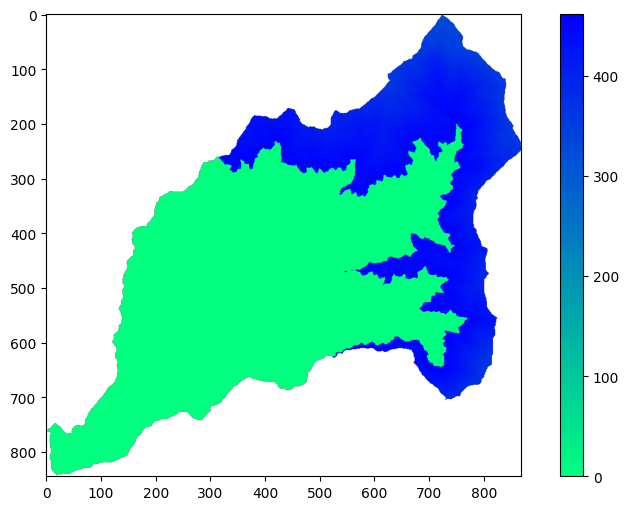

In [ ]:
plt.figure(figsize=(10, 6))
# Plot the image of the snow density map

plt.colorbar()
plt.show()

### 3.5 Compute and Plot the Watershed SWE Map

In [ ]:
dcew_swe =


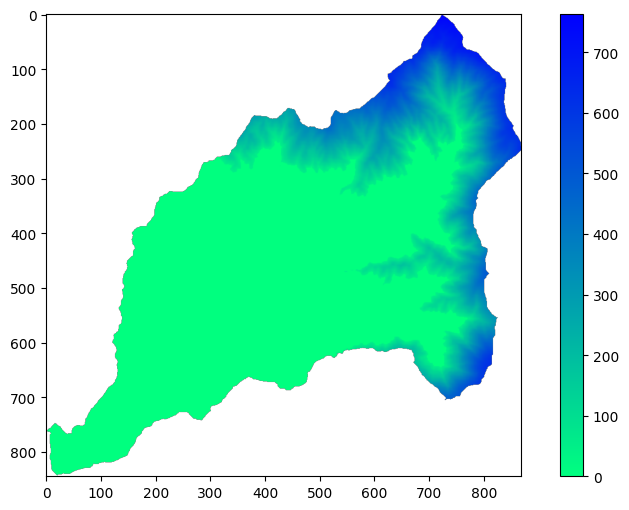

In [ ]:
plt.figure(figsize=(10, 6))
# Plot the SWE map

plt.colorbar()
plt.show()

### 3.6 Compute Watershed Snow Water Volume

In [ ]:
dcew_avg_swe = np.nanmean(dcew_swe) # Calculating the mean SWE (neglecting NaNs)
print('DCEW average SWE = '+str(dcew_avg_swe)+' mm')

In [ ]:
dcew_area = np.count_nonzero(~np.isnan(dcew_swe)) * cellsize**2 / 1000**2 # Compute the watershed area, but counting the number of non-NaN values
print('DCEW area = '+str(dcew_area)+' km^2')

In [ ]:
dcew_snow_vol = (dcew_avg_swe/1000.0) * dcew_area * 1000**2 # Calculate total snow volume
print('DCEW snow volume = '+str(dcew_snow_vol)+' m^3')

# Part B: Where Programming Gets Really Powerful

__Scenario:__ The logistics of this snow survey absolutely wrecked the undergraduates and graduate students that did it. They had to hike 5 miles – not a long distance – but over steep slopes and snow. As such, next year I need to reduce the number of survey points in my snow survey. I realize that this will lead to greater uncertainties in my estimate of snow volume, but maybe I can explore how my uncertainties change as the number of snow survey points goes down.

What I can do is sub-sample a smaller number of my 19 snow survey points (let's start with 12). I can then select 12 of my points, fit my regression lines for snow depth vs elevation and snow density vs elevation and repeat the workflow we did. But I want to do this several times with different subsamples of 12. And maybe I'd like to try different numbers of sample points. Here is an algorithm I can use to do this workflow many times and explore how it changes my snow storage estimate:

1. Define a candidate number of survey points (the size of my subsample)
2. Define the number of times I'd like to repeat my analysis
3. Create a loop through the number of times I'll repeat my analysis
  
    a. Select a random subsample of survey points
    
    b. Fit regression lines to this subsample for depth and density
    
    c. Calculate watershed maps of snow depth, density, and SWE for this subsample

    d. Calculate watershed total SWE

    e. Save the map of SWE and watershed average SWE

    f. Repeat steps a-e

4. Calculate the average SWE I would get for this number of subsamples
5. Calculate the standard deviation of SWE I would get at all points of the watershed
6. Create maps of the average and standard deviation in predicted SWE and explore where my errors are likely to be largest.

In [ ]:
n_surv_pts = 12 # Let's start with a subsample of 12 of the 19 points – Feel free to change! Must be < 19
n_trials = 50 # Let's repeat our trial this many times - Feel free to change! Larger = longer time to complete

surv_pts = np.arange(19) # These are the ID numbers of my survey points
surv_pts

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

This is the "meat" of the code. Notice that it's not that long!

In [ ]:
# Create a big data cube to store our predicted maps in
swe_trial_maps = np.nan * np.ones((dcew_swe.shape[0], dcew_swe.shape[1], n_trials))

# Create a storage container for each estimate of watershed average SWE
swe_trial_avg = np.zeros((n_trials,))

for trial in np.arange(n_trials): # Loop through all trials

  # 1. Get a random sample of my survey points that contains n_surv_pts
  surv_pts_trial = np.random.choice(surv_pts, n_surv_pts, replace=False)

  # 2. Get the elevation, snow depth, and density of those snow survey sites
  elev_trial = elev[surv_pts_trial]
  snow_depth_trial = snow_depth[surv_pts_trial]
  snow_dens_trial = snow_dens[surv_pts_trial]

  # 3. Fit a linear model to the subset of snow survey sample points
  depth_coef_trial = np.polyfit(elev_trial, snow_depth_trial, 1)
  dens_coef_trial = np.polyfit(elev_trial, snow_dens_trial, 1)

  # 4. Get the linear model coefficients for the snow depth model
  a_trial = depth_coef_trial[0]
  b_trial = depth_coef_trial[1]

  # 5. Get the linear model coefficients for the snow density model
  c_trial = dens_coef_trial[0]
  d_trial = dens_coef_trial[1]

  # 6. Compute the map of snow depth for this trial of random sample points
  dcew_snow_depth_trial = np.nan * np.ones(dcew_dem.shape)
  dcew_snow_depth_trial[dcew_dem<snowline_elev] = 0
  dcew_snow_depth_trial[dcew_dem>=snowline_elev] = a_trial*dcew_dem[dcew_dem>=snowline_elev] + b_trial

  # 7. Compute the map of snow density for this trial of random sample points
  dcew_snow_dens_trial = np.nan * np.ones(dcew_dem.shape)
  dcew_snow_dens_trial[dcew_dem<snowline_elev] = 0
  dcew_snow_dens_trial[dcew_dem>=snowline_elev] = c_trial*dcew_dem[dcew_dem>=snowline_elev] + d_trial

  # 8. Compute the map of SWE in DCEW for this trial of random sample points
  dcew_swe_trial = dcew_snow_depth_trial * (dcew_snow_dens_trial / 1000.0)

  # 9. Store the map of SWE for this subset of survey points
  swe_trial_maps[:, :, trial] = dcew_swe_trial

  # 10. Store the average watershed SWE for this subset of survey points
  swe_trial_avg[trial] = np.nanmean(dcew_swe_trial)

  # 11. Now go repeat that analysis for a different (random) subset of survey points


Now let's analyze, plot, and interpret the results.

In [ ]:
# Compute the average SWE map over all trials
dcew_swe_mean = np.mean(swe_trial_maps, axis=2)

# Compute the standard deviation across all trials
dcew_swe_std = np.std(swe_trial_maps, axis=2)

# Create maps of the average and standard deviation in SWE
plt.figure(figsize=(8, 12))
plt.subplot(2,1,1)
plt.imshow(dcew_swe_mean, cmap='winter_r')
plt.colorbar()
plt.title('Mean SWE')
plt.subplot(2,1,2)
plt.imshow(dcew_swe_std, cmap='winter_r')
plt.colorbar()
plt.title('Standard Deviation of SWE')
plt.show()

Interesting. A couple of thoughts to ponder:

*   Where are my potential errors the highest?
*   Where are my potential errors the lowest?
*   Does this make sense?


Finally, let's create a histogram of our watershed average estimates of SWE for our different sub-samples. We want to see the range of estimates we got with different random subsamples, and see whether they cluster in a particular region of SWE.



In [ ]:
# Numpy actually makes it pretty easy to create histograms
swe_bins, swe_bin_edges = np.histogram(swe_trial_avg, bins=12)

# Some inside baseball: np.histogram returns edges of histogram bins. We want centers
swe_bin_centers = (swe_bin_edges[1:] + swe_bin_edges[:-1])/2

plt.figure(figsize=(8, 5))
plt.bar(swe_bin_centers, swe_bins, width=(swe_bin_centers[1]-swe_bin_centers[0]))
plt.xlabel('DCEW Average SWE (mm)')
plt.ylabel('Frequency')
plt.title('Distribution of SWE')
plt.show()